In [84]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import torchvision
from torchvision import transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import time
from timm.data.mixup import Mixup
from timm.loss import SoftTargetCrossEntropy

In [92]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")

In [93]:
train_data = torchvision.datasets.SVHN(root = './data', download = True, split = 'train', transform = transforms.ToTensor())
test_data = torchvision.datasets.SVHN(root = './data', download = True, split = 'test', transform = transforms.ToTensor())

tensor([[[0.5059, 0.4667, 0.4510,  ..., 0.5647, 0.5490, 0.5451],
         [0.4353, 0.3882, 0.3294,  ..., 0.5686, 0.5569, 0.5529],
         [0.4235, 0.3608, 0.2667,  ..., 0.5725, 0.5686, 0.5647],
         ...,
         [0.4039, 0.3490, 0.2941,  ..., 0.2157, 0.3020, 0.4196],
         [0.4078, 0.3333, 0.3333,  ..., 0.2078, 0.2824, 0.3961],
         [0.4039, 0.3176, 0.3294,  ..., 0.2510, 0.3176, 0.4078]],

        [[0.4980, 0.4667, 0.4431,  ..., 0.5373, 0.5373, 0.5412],
         [0.4314, 0.3843, 0.3176,  ..., 0.5451, 0.5451, 0.5490],
         [0.4196, 0.3608, 0.2549,  ..., 0.5373, 0.5451, 0.5490],
         ...,
         [0.4118, 0.3529, 0.2902,  ..., 0.2353, 0.3176, 0.4314],
         [0.4157, 0.3490, 0.3451,  ..., 0.2353, 0.3059, 0.4118],
         [0.4118, 0.3333, 0.3569,  ..., 0.2784, 0.3412, 0.4235]],

        [[0.4471, 0.4118, 0.3961,  ..., 0.4745, 0.4627, 0.4627],
         [0.3961, 0.3608, 0.3020,  ..., 0.4902, 0.4784, 0.4824],
         [0.4078, 0.3569, 0.2706,  ..., 0.4980, 0.5020, 0.

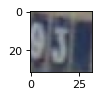

In [94]:
img, label = train_data[7]
plt.figure(figsize=(1,1), dpi=80)
plt.imshow(img.permute(1,2,0))
print(img)
print(label)

In [95]:
train_batch_loader = DataLoader(train_data, batch_size = 8, shuffle = True, pin_memory = True, num_workers = 2)
test_batch_loader = DataLoader(test_data, batch_size = 8, shuffle = True, pin_memory = True, num_workers = 2)

In [69]:
mean = torch.zeros(3)
std = torch.zeros(3)
nb_samples = 0

# Iterate over the training DataLoader to compute mean and std.
for data, _ in train_batch_loader:
    batch_samples = data.size(0)
    # Reshape: (batch_size, channels, height * width)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples
print(mean, std)

tensor([0.4377, 0.4438, 0.4728]) tensor([0.1201, 0.1231, 0.1052])


In [70]:
transform_train = transforms.Compose([
    # transforms.Resize(244),
    transforms.RandomCrop(32, padding = 4),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # transforms.Scale(0.1),
    # transforms.Translate(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform_test = transforms.Compose([
    # transforms.Resize(244),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [71]:
train_data = torchvision.datasets.SVHN(root = './data', download = True, split = 'train', transform = transform_train)
test_data = torchvision.datasets.SVHN(root = './data', download = True, split = 'test', transform = transform_test)

In [72]:
train_batch_loader = DataLoader(train_data, batch_size = 8, shuffle = True, pin_memory = True, num_workers = 2)
test_batch_loader = DataLoader(test_data, batch_size = 8, shuffle = True, pin_memory = True, num_workers = 2)

In [73]:
class SVHNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = (3,3), padding = 1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size = (3,3), padding = 1)
        self.batchnorm2 = nn.BatchNorm2d(32)

        
        self.conv3 = nn.Conv2d(32, 64, kernel_size = (3,3), padding = 1)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size = (3,3), padding = 1)
        self.batchnorm4 = nn.BatchNorm2d(64)

        
        self.conv5 = nn.Conv2d(64, 128, kernel_size = (3,3), padding = 1)
        self.batchnorm5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size = (3,3), padding = 1)
        self.batchnorm6 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2,2)

        self.fc_input_size = 128 * 4 * 4

        self.fc1 = nn.Linear(self.fc_input_size, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x))) 
        x = F.relu(self.batchnorm2(self.conv2(x))) 
        x = self.pool(x)
        x = F.relu(self.batchnorm3(self.conv3(x))) 
        x = F.relu(self.batchnorm4(self.conv4(x))) 
        x = self.pool(x)
        x = F.relu(self.batchnorm5(self.conv5(x))) 
        x = F.relu(self.batchnorm6(self.conv6(x))) 
        x = self.pool(x)
        
        x = x.view(x.shape[0], -1)

        x = self.dropout(F.relu(self.fc1(x)))

        x = self.fc2(x)

        return x

In [97]:

model = SVHNModel()
model.to(device)

# loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr = 0.001)

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
epochs = 30
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=3e-4, steps_per_epoch=len(train_batch_loader), epochs=epochs
)

# Step 1: Define MixUp & CutMix augmentation
mixup_fn = Mixup(
    mixup_alpha=0.2,    # Strength of MixUp
    cutmix_alpha=1.0,   # Strength of CutMix
    prob=0.5,           # Probability of applying MixUp/CutMix
    switch_prob=0.5,    # Probability of switching between MixUp & CutMix
    mode="batch",
    num_classes=10
)

for epoch in range(epochs):
    for i, each in enumerate(train_batch_loader):
        t_in = time.time()
        x_train, y_train = each
        x_train, y_train = x_train.to(device), y_train.to(device)

        # Step 3: Apply MixUp/CutMix augmentation to the batch
        if mixup_fn is not None and x_train.size(0) % 2 == 0:
            x_train, y_train = mixup_fn(x_train, y_train)
            
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()

        if i == 0 and epoch == 0:
            time_taken = time.time() - t_in
            estimated_time = time_taken * len(train_batch_loader) * epochs
            print("Estimated time: ", estimated_time - time_taken)
            print(estimated_time / 60)
    scheduler.step()
                    
    print(f"epoch: {epoch}, loss: {loss}")
        

Estimated time:  2158.9749908447266
35.98304748535156
epoch: 0, loss: 1.1738388538360596
epoch: 1, loss: 0.688119649887085
epoch: 2, loss: 0.5614855289459229
epoch: 3, loss: 0.6017897129058838
epoch: 4, loss: 0.6496078372001648
epoch: 5, loss: 0.5799174904823303
epoch: 6, loss: 0.6481634378433228
epoch: 7, loss: 2.192373037338257
epoch: 8, loss: 0.8157390356063843
epoch: 9, loss: 1.4136197566986084
epoch: 10, loss: 0.5352967977523804
epoch: 11, loss: 0.5496277809143066
epoch: 12, loss: 0.5423702597618103
epoch: 13, loss: 0.8656830787658691
epoch: 14, loss: 0.5980850458145142
epoch: 15, loss: 0.6030501127243042
epoch: 16, loss: 1.355538010597229
epoch: 17, loss: 0.5377591252326965
epoch: 18, loss: 0.620063066482544
epoch: 19, loss: 0.5947952270507812
epoch: 20, loss: 0.7572160959243774
epoch: 21, loss: 0.63004469871521
epoch: 22, loss: 0.5282595753669739
epoch: 23, loss: 0.7148165702819824
epoch: 24, loss: 0.7110122442245483
epoch: 25, loss: 0.5298326015472412
epoch: 26, loss: 1.2183411

In [98]:
def check_accuracy(model, test_batch_loader):
    total = 0
    correct = 0
    for i, each in enumerate(test_batch_loader):
        x_test, y_test = each
        x_test, y_test = x_test.to(device), y_test.to(device)

        y_pred = model(x_test)
        total += x_test.shape[0]
        _, pred = torch.max(y_pred, 1)
        correct += (pred == y_test).sum().item()
    return 100 * correct / total

print(check_accuracy(model, test_batch_loader))
        

93.57713583282114


In [79]:
# 90.411 (Normal), 
# 89.56 (with mixup)
# 92.5 (with OneCycleLR)
# 93.57 (Without doing transformation)

/tmp/ipykernel_159671/4048963178.py:58: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)
/tmp/ipykernel_159671/4048963178.py:70: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


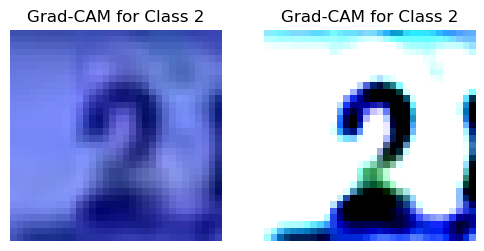

In [91]:

# Global variables to store activations and gradients
activations = None
gradients = None

# Hook to save the activations (forward pass)
def forward_hook(module, input, output):
    global activations
    activations = output

# Hook to save the gradients (backward pass)
def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

# Assume `model` is your SVHNModel (or similar CNN) and it's already on the correct device.
# Choose the target convolutional layer; here we use conv6.
target_layer = model.conv6

# Register hooks
hook_forward = target_layer.register_forward_hook(forward_hook)
hook_backward = target_layer.register_backward_hook(backward_hook)

# Get a single image from your SVHN test dataset.
# For example, assume 'sample_img' is one image tensor of shape (3, 32, 32)
# and 'label' is its true label.
# Make sure the image is preprocessed (transformed) and unsqueeze to add batch dimension.
sample_img, label = test_data[1]  # Replace with an index you want to inspect.
input_img = sample_img.unsqueeze(0).to(device)  # shape: (1, 3, 32, 32)

# Set model to evaluation mode and do a forward pass.
model.eval()
output = model(input_img)  # shape: (1, 10)

# Choose a target class. You can use the predicted class:
target_class = output.argmax(dim=1).item()
# Alternatively, you could specify a class manually:
# target_class = 3  (for example)

# Zero gradients and perform a backward pass for the target class score.
model.zero_grad()
score = output[0, target_class]
score.backward()

# Now compute the Grad-CAM heatmap.
# gradients: shape (1, C, H, W) from conv6
# activations: shape (1, C, H, W) from conv6

# Compute the weights by global-average pooling the gradients over spatial dimensions.
weights = torch.mean(gradients, dim=(2, 3), keepdim=True)  # shape: (1, C, 1, 1)

# Compute the weighted sum of the activations.
cam = torch.sum(weights * activations, dim=1)  # shape: (1, H, W)
cam = F.relu(cam)  # Apply ReLU to the combined map.
cam = cam.squeeze().detach().cpu().numpy()  # Now shape is (H, W)

# Normalize the CAM to [0, 1].
cam = cam - np.min(cam)
cam = cam / np.max(cam)

# Upsample the CAM to the size of the input image (e.g., 32x32).
cam = cv2.resize(cam, (input_img.shape[3], input_img.shape[2]))

# Visualize: overlay the heatmap on the original image.
# Convert the input image to numpy (and to HWC order).
input_img_np = input_img.squeeze().permute(1, 2, 0).detach().cpu().numpy()
input_img_np = input_img_np - np.min(input_img_np)
input_img_np = input_img_np / np.max(input_img_np)

# Apply a color map to the CAM.
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Combine heatmap with the original image.
overlay = heatmap + input_img_np
overlay = overlay / np.max(overlay)

# Plot the overlay.
plt.figure(figsize=(6, 6))
plt.subplot(1,2,1)
plt.imshow(overlay)
plt.title(f"Grad-CAM for Class {target_class}")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(sample_img.permute(1, 2, 0))
plt.title(f"Grad-CAM for Class {target_class}")
plt.axis('off')
plt.show()

# Remove hooks after usage.
hook_forward.remove()
hook_backward.remove()
